In [ ]:
!unzip /content/python.zip

In [ ]:
!unzip /content/Reacher_Linux_NoVis_20_Agent.zip

In [5]:
%cd /content

/content


In [ ]:
!python setup.py install

**1. Start the Environment**

In [1]:
import time
import copy
import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment

#DDPG Agent hyperparameters
batch_size = 128
buffer_size = int(1e5)
gamma = 0.99
lr_actor = 1e-3
lr_critic = 1e-3
tau = 1e-3
noise_decay = 0.999


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
target_score = 30.0
target_episodes = 50

env = UnityEnvironment(file_name='/content/Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

**2. Examine the State and Action Spaces**

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


**3.Defining the Agent, NN and train function**

In [4]:

def _reset_parameters(layers):
    for layer in layers:
        layer.weight.data.uniform_(-3e-3,3e-3)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[128, 128], dropout_p=0.2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
            dropout_p (float): Dropout probability
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        dims = [state_size] + fc_layers + [action_size]
        self.fc_layers = nn.ModuleList(
            [nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])]
        )
        self.dropout = nn.Dropout(dropout_p)
        self.bn = nn.BatchNorm1d(fc_layers[-1])  # Apply batch normalization

        _reset_parameters(self.fc_layers)

        #print('Actor network built:', self.fc_layers)

    def forward(self, x):
        """Build an actor (policy) network that maps states -> actions."""
        for layer in self.fc_layers[:-1]:
            x = F.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after each ReLU
        x = self.bn(x)  # Apply batch normalization
        x = torch.tanh(self.fc_layers[-1](x))
        return x

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc_layers=[128, 128], dropout_p=0.2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_layers (list): Number of nodes in hidden layers
            dropout_p (float): Dropout probability
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        dims = fc_layers + [1]
        layers_list = [nn.Linear(state_size, dims[0])]
        layers_list.append(nn.Linear(dims[0] + action_size, dims[1]))
        for dim_in, dim_out in zip(dims[1:-1], dims[2:]):
            layers_list.append(nn.Linear(dim_in, dim_out))

        self.fc_layers = nn.ModuleList(layers_list)
        self.dropout = nn.Dropout(dropout_p)
        self.bn = nn.BatchNorm1d(dims[0])

        _reset_parameters(self.fc_layers)

        #print('Critic network built:', self.fc_layers)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = F.relu(self.fc_layers[0](state))
        x = self.bn(x)
        x = torch.cat((x, action), dim=1)
        for layer in self.fc_layers[1:-1]:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = torch.sigmoid(self.fc_layers[-1](x))
        return x


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network
        self.actor_local = Actor(state_size, action_size, random_seed, [400, 300]).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, [400, 300]).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)

        # Critic Network
        self.critic_local = Critic(state_size, action_size, random_seed, [400, 300]).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, [400, 300]).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic)

        # Initialize target networks weights with the local networks ones
        self.soft_update(self.actor_local, self.actor_target, 1)
        self.soft_update(self.critic_local, self.critic_target, 1)

        # Replay Buffer
        self.replay_buffer = ReplayBuffer(random_seed)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_decay = noise_decay

    def act(self, state, noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).data.cpu().numpy()
        self.actor_local.train()

        if noise:
            # Add noise to the action in order to explore the environment
            action += self.noise_decay * self.noise.sample()
            # Decay the noise process along the time
            self.noise_decay *= self.noise_decay

        return np.clip(action, -1, 1)

    def step(self, states, actions, rewards, next_states):
        """Save experience in replay buffer, and use random sample from buffer to learn."""
        # Save experience
        self.replay_buffer.add(states, actions, rewards, next_states)

        # Learn, if enough samples are available in memory
        if len(self.replay_buffer) > batch_size:
            experiences = self.replay_buffer.sample()
            self.learn(experiences)

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s') tuples
        """
        states, actions, rewards, next_states = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions from actor_target model
        actions_next = self.actor_target(next_states)
        # Get predicted next-state Q-Values from critic_target model
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next)
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)

    def soft_update(self, local_model, target_model, tau=tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    ## Define the training function
    def train(self,n_episodes=2000, max_t=1000):
      """Deep Deterministic Policy Gradients (DDPG).

      Params
      ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
      """
      scores = []      # episodic scores
      moving_avg = []  # moving average over 100 episodes and over all agents
      ## Perform n_episodes of training
      time_training_start = time.time()
      for i_episode in range(1, n_episodes+1):
          time_episode_start = time.time()
          self.noise.reset()
          states = env.reset(train_mode=True)[brain_name].vector_observations
          scores_episode = np.zeros(num_agents)           # rewards per episode for each agent

          for t in range(1, max_t+1):
              # Perform a step: S;A;R;S'
              actions = self.act(states)                 # select the next action for each agent
              env_info = env.step(actions)[brain_name]    # send the actions to the environment
              rewards = env_info.rewards                  # get the rewards
              next_states = env_info.vector_observations  # get the next states
              # Send the results to the Agent
              for (state, action, reward, next_state) \
                      in zip(states, actions, rewards, next_states):
                  self.step(state, action, reward, next_state)
              # Update the variables for the next iteration
              states = next_states
              scores_episode += rewards

          # Store the rewards and calculate the moving average
          scores.append(scores_episode.tolist())
          moving_avg.append(np.mean(scores[-target_episodes:], axis=0))
          # Calculate the elapsed time
          time_episode = time.time() - time_episode_start
          time_elapsed = time.time() - time_training_start
          time_episode_str = time.strftime('%Mm%Ss', time.gmtime(time_episode))

          ## Print the results for this episode
          print('Episode {:3d} \tScore: {:5.2f} \t' \
              'Average: {:5.2f} ' \
              .format(i_episode, scores_episode.mean(),moving_avg[-1].mean()))

          ## Check if the environment has been solved
          if moving_avg[-1].mean() >= target_score and i_episode >= target_episodes:
            time_elapsed_str = time.strftime('%Hh%Mm%Ss', time.gmtime(time_elapsed))
            print('\nEnvironment solved in {:d} episodes!\t' \
                  'Average Score: {:.2f}\tElapsed time: {}'
                  .format(i_episode-target_episodes, moving_avg[-1].mean(),
                          time_elapsed_str))

              ## Save the model along with some training information
            checkpoint = {
                'actor_dict': self.actor_local.state_dict(),
                'critic_dict': self.critic_local.state_dict(),
                'ddpg_params': {
                    'batch_size': batch_size,
                    'buffer_size': buffer_size,
                    'gamma': gamma,
                    'lr_actor': lr_actor,
                    'lr_critic': lr_critic,
                    'tau': tau,
                    },
                'episodes': i_episode,
                'elapsed_time': time_elapsed_str,
                'scores': scores,
                'moving_avg': moving_avg,
                }
            print('\nSaving model ...', end=' ')
            torch.save(checkpoint, '/content/Weights/checkpoint.pt')
            print('done.')

            break

      return scores, moving_avg



class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple('Experience', field_names=['states', 'actions', 'rewards', 'next_states'])
        self.seed = random.seed(seed)

    def add(self, states, actions, rewards, next_states):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=batch_size)

        states = torch.from_numpy(np.vstack([e.states for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.actions for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_states for e in experiences if e is not None])).float().to(device)

        return (states, actions, rewards, next_states)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

**4. Training NN**

In [5]:
# Create the Agent
agent = Agent(state_size, action_size, random_seed=0)

In [6]:
# Train the Agent
scores, moving_avg=agent.train()

Episode   1 	Score:  0.66 	Average:  0.66 
Episode   2 	Score:  1.91 	Average:  1.28 
Episode   3 	Score:  2.75 	Average:  1.77 
Episode   4 	Score:  5.20 	Average:  2.63 
Episode   5 	Score: 10.42 	Average:  4.19 
Episode   6 	Score: 13.99 	Average:  5.82 
Episode   7 	Score: 20.34 	Average:  7.90 
Episode   8 	Score: 25.66 	Average: 10.12 
Episode   9 	Score: 32.86 	Average: 12.64 
Episode  10 	Score: 33.28 	Average: 14.71 
Episode  11 	Score: 33.62 	Average: 16.43 
Episode  12 	Score: 32.03 	Average: 17.73 
Episode  13 	Score: 32.26 	Average: 18.85 
Episode  14 	Score: 35.16 	Average: 20.01 
Episode  15 	Score: 31.67 	Average: 20.79 
Episode  16 	Score: 32.90 	Average: 21.54 
Episode  17 	Score: 35.62 	Average: 22.37 
Episode  18 	Score: 36.41 	Average: 23.15 
Episode  19 	Score: 38.10 	Average: 23.94 
Episode  20 	Score: 34.18 	Average: 24.45 
Episode  21 	Score: 37.91 	Average: 25.09 
Episode  22 	Score: 37.17 	Average: 25.64 
Episode  23 	Score: 33.30 	Average: 25.97 
Episode  24

**5.Plot of Rewards**

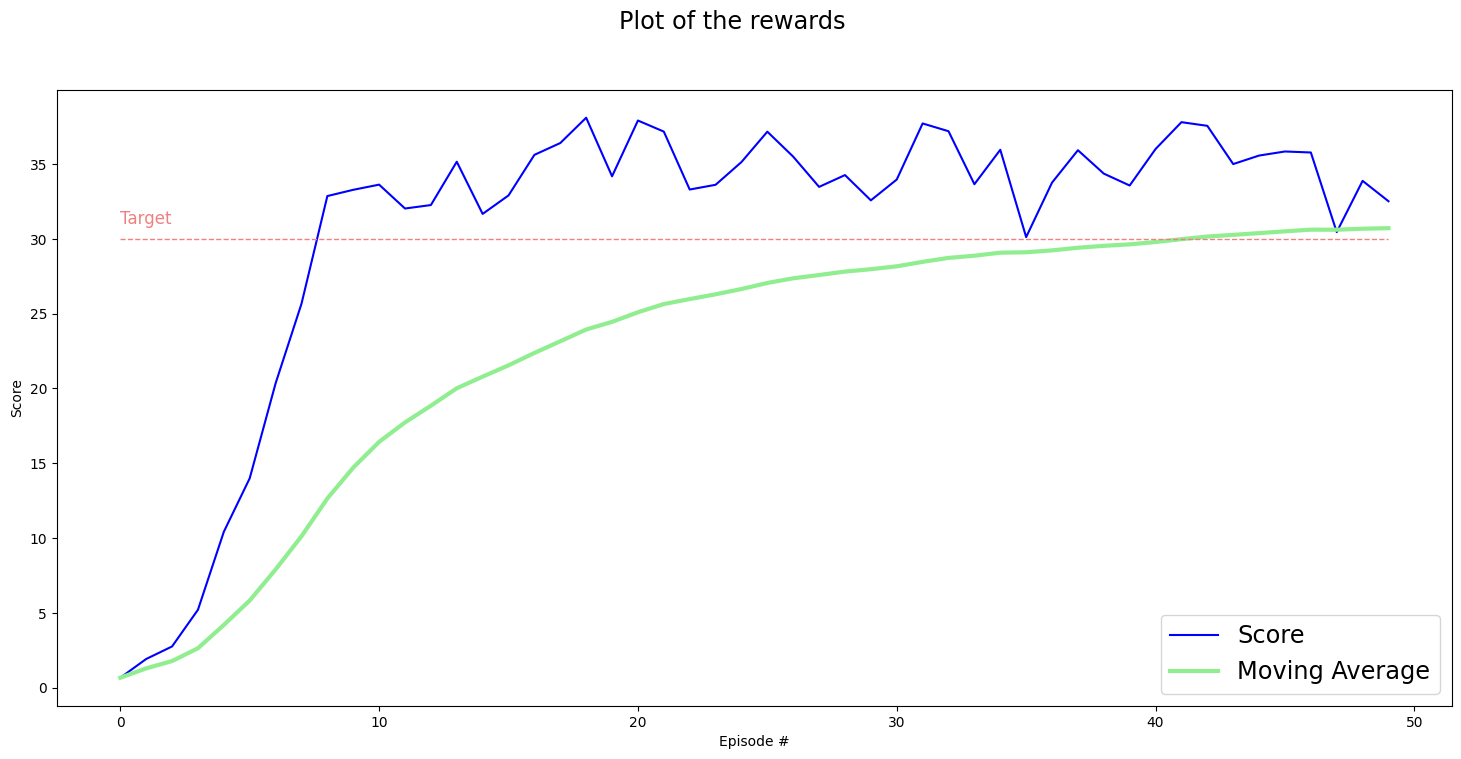

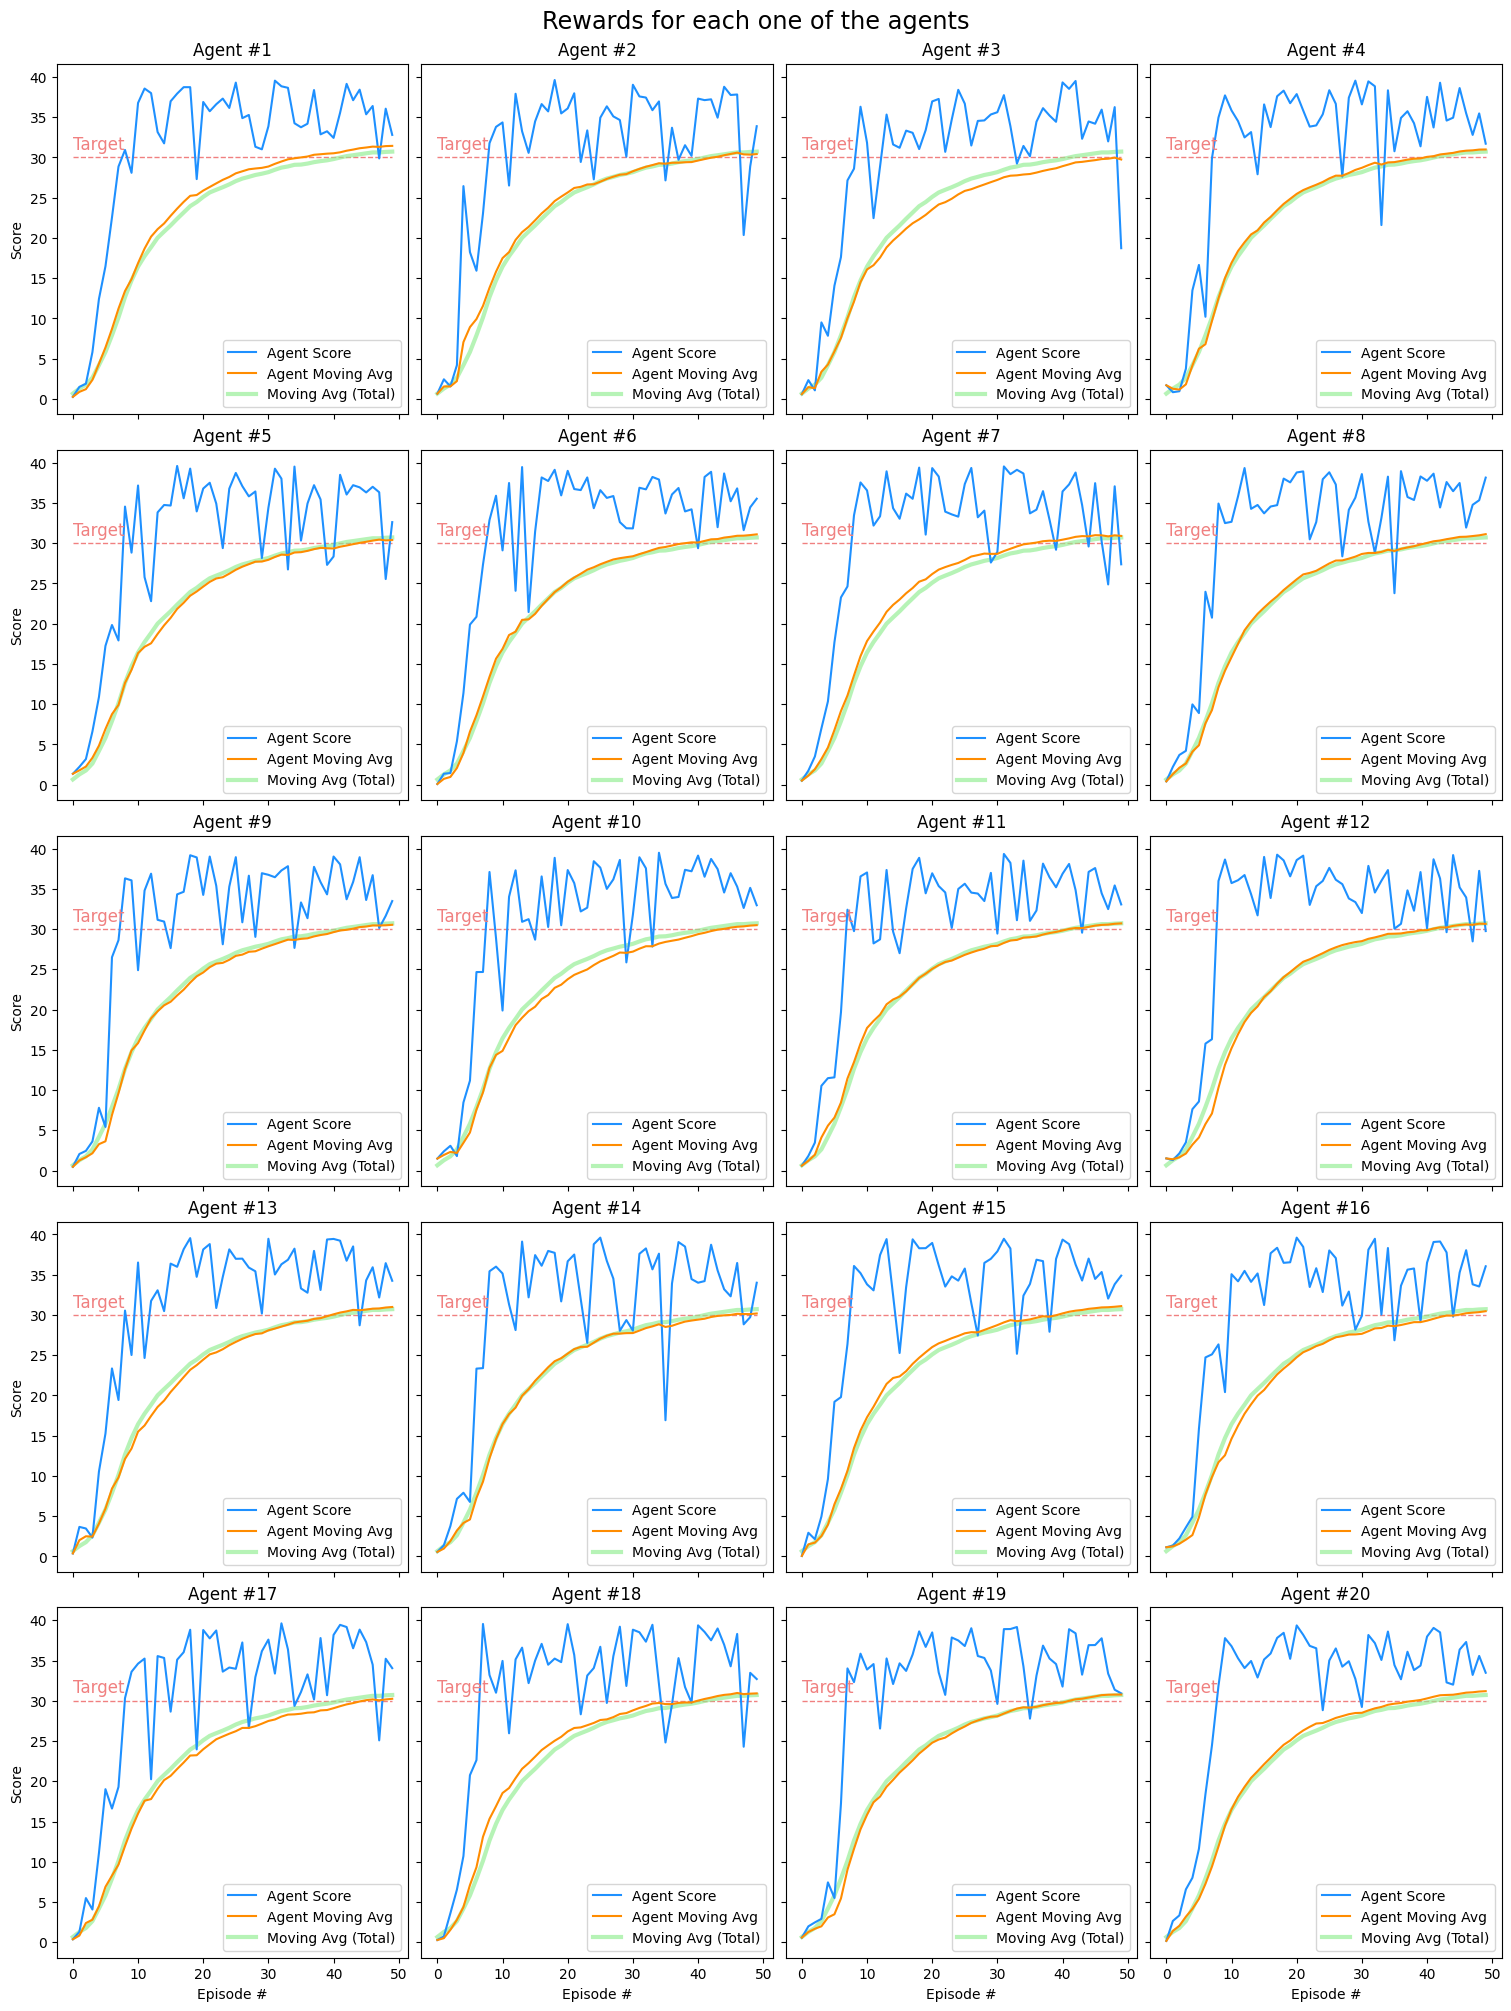

In [7]:
# Preprocess some variables
scores_mean = np.mean(scores, axis=1)
moving_avg_mean = np.mean(moving_avg, axis=1)
target = [target_score] * len(scores) # Trace a line indicating the target value

# Plot the main graph with the scores and moving average
fig = plt.figure(figsize=(18,8))
fig.suptitle('Plot of the rewards', fontsize='xx-large')

ax = fig.add_subplot(111)
ax.plot(scores_mean, label='Score', color='Blue')
ax.plot(moving_avg_mean, label='Moving Average',
        color='LightGreen', linewidth=3)
ax.plot(target, linestyle='--', color='LightCoral', linewidth=1 )
ax.text(0, target_score+1, 'Target', color='LightCoral', fontsize='large')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='xx-large', loc='lower right')

plt.show()

# Plot one graph for each one of the 20 Agents, if that is the case
if len(scores[0]) == 20:
    fig, axs = plt.subplots(5, 4, figsize=(15, 20),
                            constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle('Rewards for each one of the agents', fontsize='xx-large')

    axs = axs.flatten()
    for idx, (ax, s, m) \
            in enumerate(zip(axs, np.transpose(scores), np.transpose(moving_avg))):
        ax.plot(s, label='Agent Score', color='DodgerBlue', zorder=2)
        ax.plot(m, label='Agent Moving Avg', color='DarkOrange', zorder=3)
        ax.plot(moving_avg_mean, label='Moving Avg (Total)',
                color='LightGreen', linewidth=3, alpha=0.655, zorder=1)
        ax.plot(target, linestyle='--', color='LightCoral', linewidth=1, zorder=0)
        ax.text(0, target_score+1, 'Target', color='LightCoral', fontsize='large')

        ax.set_title('Agent #%d' % (idx+1))
        ax.set_ylabel('Score')
        ax.set_xlabel('Episode #')
        ax.label_outer()
        ax.legend(fontsize='medium')

    plt.show()


**6.When finished, you can close the environment.**

In [ ]:
env.close()